In [1]:
!pip install rasterio

import os
import shutil
import random
import copy
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os.path as osp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.utils.data import DataLoader

import torchvision
from tqdm import tqdm, notebook as tqdm_notebook
import rasterio
from osgeo import gdal

data_root = '/kaggle/input/2023-ieee-grss-data-fusion-contest/track2'



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 78.5 MB/s eta 0:00:00:00:0100:01


## Data root directory where we store the rgb, sar, dsm data


## Here, we merge the rgb and sar data together and store it in '/kaggle/working/track2/train/merge'


In [2]:
def read_img(filename):
    dataset = gdal.Open(filename)
    im_data = dataset.ReadAsArray()
    im_proj = dataset.GetProjection()
    im_geotrans = dataset.GetGeoTransform()
    return im_data, im_proj, im_geotrans

def write_img(filename, im_proj, im_geotrans, im_data):
    if len(im_data.shape) == 3:
        bands, height, width = im_data.shape
    else:
        bands, (height, width) = 1, im_data.shape

    driver = gdal.GetDriverByName("GTiff")
    datatype = gdal.GDT_Float32
    dataset = driver.Create(filename, width, height, bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)

    if bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
    del dataset

def make_merge(rgb_path, sar_path, merge_path):
    data_rgb, proj, geotrans = read_img(rgb_path)
    data_sar, _, _ = read_img(sar_path)
    if data_sar.ndim == 2:
        data_sar = data_sar[np.newaxis, :, :]
    data_merge = np.concatenate([data_rgb, data_sar], axis=0)
    write_img(merge_path, proj, geotrans, data_merge)

# Merge all RGB and SAR images into 4-channel
root = os.path.join(data_root, 'train')
merged_dir = os.path.join('/kaggle/working/track2/train/merge')
os.makedirs(merged_dir, exist_ok=True)

rgb_dir = os.path.join(root, 'rgb')
sar_dir = os.path.join(root, 'sar')

for f in tqdm(os.listdir(rgb_dir)):
    if f.endswith('.tif') and os.path.exists(os.path.join(sar_dir, f)):
        rgb_path = os.path.join(rgb_dir, f)
        sar_path = os.path.join(sar_dir, f)
        merge_path = os.path.join(merged_dir, f)
        make_merge(rgb_path, sar_path, merge_path)

print("✅ Merged RGB + SAR saved to:", merged_dir)

100%|██████████| 1773/1773 [01:47<00:00, 16.45it/s]

✅ Merged RGB + SAR saved to: /kaggle/working/track2/train/merge


## Here we copy the dsm files to the kaggle working directory and convert them to numpy arrays


In [3]:
src_folder = os.path.join(data_root, "train", "dsm")  # ✅ fixed
dst_folder = "/kaggle/working/track2/train/dsm"

os.makedirs(dst_folder, exist_ok=True)

# Copy only .tif files
for f in os.listdir(src_folder):
    if f.endswith(".tif"):
        shutil.copy(os.path.join(src_folder, f), os.path.join(dst_folder, f))

print("✅ DSM .tif files copied to writable folder.")

tif_folder = "/kaggle/working/track2/train/dsm"
npy_folder = "/kaggle/working/track2/train/dsmnpy"
os.makedirs(npy_folder, exist_ok=True)

for fname in os.listdir(tif_folder):
    if fname.endswith(".tif"):
        tif_path = os.path.join(tif_folder, fname)
        npy_path = os.path.join(npy_folder, fname.replace(".tif", ".npy"))

        with rasterio.open(tif_path) as src:
            arr = src.read(1)
            np.save(npy_path, arr)

print("✅ DSM conversion to .npy complete.")

✅ DSM .tif files copied to writable folder.
✅ DSM conversion to .npy complete.


## Here, we create divide the training folder into train (70%), validation (20%), and test (10%), put the image ids into seperate files and store them


In [4]:
rgb_dir = os.path.join(data_root, "train", "rgb")  # ✅ use original
dsm_dir = "/kaggle/working/track2/train/dsmnpy"    # ✅ use working dir for npy DSMs

all_merge = [f for f in os.listdir(rgb_dir) if f.endswith(".tif")]
valid_samples = []

for f in all_merge:
    name = os.path.splitext(f)[0]
    if os.path.exists(os.path.join(dsm_dir, f"{name}.npy")):
        valid_samples.append(name)

random.shuffle(valid_samples)
train_split = int(0.7 * len(valid_samples))
val_split = int(0.9 * len(valid_samples))

train_ids = valid_samples[:train_split]
val_ids = valid_samples[train_split:val_split]
test_ids = valid_samples[val_split:]

with open("/kaggle/working/train_list.txt", 'w') as f:
    f.write("\n".join(train_ids))
with open("/kaggle/working/val_list.txt", 'w') as f:
    f.write("\n".join(val_ids))
with open("/kaggle/working/test_list.txt", 'w') as f:
    f.write("\n".join(test_ids))

print("✅ Split lists saved (train/val/test)")


✅ Split lists saved (train/val/test)


## The next two cells are for data loading, now we create the dataset class, and then load the images


In [5]:
class ISPRSDataSet(data.Dataset):
    def __init__(self, root, list_path, crop_size=(512, 512), mean=(128, 128, 128, 128), scale=False, mirror=True):
        self.root = root
        self.list_path = list_path
        self.crop_h, self.crop_w = crop_size
        self.mean = mean
        self.scale = scale
        self.is_mirror = mirror
        self.img_ids = [i_id.strip() for i_id in open(list_path)]
        self.files = []

        for name in self.img_ids:
            img_file = osp.join(self.root, "merge/%s.tif" % name)
            dsm_file = osp.join(self.root, "dsmnpy/%s.npy" % name)
            self.files.append({
                "img": img_file,
                "dsm": dsm_file,
                "name": name
            })

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        datafiles = self.files[index]
        # Read 4‑channel image as (C, H, W)
        with rasterio.open(datafiles["img"]) as src:
            image = src.read().astype(np.float32)
        # Read DSM as (H, W, 1)
        dsm = np.load(datafiles["dsm"]).astype(np.float32)
        dsm = np.reshape(dsm, (dsm.shape[0], dsm.shape[1], 1))

        # Normalize
        image = image - np.array(self.mean)[:, None, None]
        # dsm = dsm / 183.17412
    
        # --- Crop center ---
        _, h, w = image.shape
        if h < self.crop_h or w < self.crop_w:
            raise ValueError(f"Cannot crop to {self.crop_h}×{self.crop_w} from image size {h}×{w}")
        h_off = (h - self.crop_h) // 2
        w_off = (w - self.crop_w) // 2
    
        # Channel‑first crop
        image = image[:, h_off:h_off + self.crop_h, w_off:w_off + self.crop_w]
        dsm = dsm[h_off:h_off + self.crop_h, w_off:w_off + self.crop_w, :]
    
        # Transpose DSM to (1, H, W)
        dsm = dsm.transpose((2, 0, 1))

        dsm_log = np.log1p(dsm) / np.log1p(184)
    
        return image.copy(), dsm_log.copy(), (h, w), datafiles["name"]


In [6]:
final_data_root = "/kaggle/working/track2/train"

train_dataset = ISPRSDataSet(
    root=final_data_root,
    list_path="/kaggle/working/train_list.txt",
    crop_size=(512, 512)
)

val_dataset = ISPRSDataSet(
    root=final_data_root,
    list_path="/kaggle/working/val_list.txt",
    crop_size=(512, 512)
)

test_dataset = ISPRSDataSet(
    root=final_data_root,
    list_path="/kaggle/working/test_list.txt",
    crop_size=(512, 512)
)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, drop_last=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, drop_last=True, num_workers=2)


# From this point onwards, we are building the model


## The model architecture


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import convnext_base

class PSPModule(nn.Module):
    def __init__(self, features, out_features=512, sizes=(1, 2, 3, 6)):
        super(PSPModule, self).__init__()
        self.stages = nn.ModuleList([
            self._make_stage(features, out_features, size) for size in sizes
        ])
        self.bottleneck = nn.Sequential(
            nn.Conv2d(features + len(sizes) * out_features, out_features, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_features),
            nn.Dropout2d(0.1)
        )

    def _make_stage(self, features, out_features, size):
        prior = nn.AdaptiveAvgPool2d(output_size=(size, size))
        conv = nn.Conv2d(features, out_features, kernel_size=1, bias=False)
        bn = nn.BatchNorm2d(out_features)
        return nn.Sequential(prior, conv, bn)

    def forward(self, feats):
        h, w = feats.size(2), feats.size(3)
        priors = [F.interpolate(stage(feats), size=(h, w), mode='bilinear', align_corners=True) for stage in self.stages] + [feats]
        bottle = self.bottleneck(torch.cat(priors, 1))
        return bottle

class UPerDecoder(nn.Module):
    def __init__(self, in_channels_list, psp_in_channels, psp_out_channels, final_out_channels):
        super().__init__()
        self.psp = PSPModule(psp_in_channels, psp_out_channels)
        self.lateral_convs = nn.ModuleList([
            nn.Conv2d(ch, psp_out_channels, kernel_size=1) for ch in in_channels_list[:-1]
        ])
        self.fpn_convs = nn.ModuleList([
            nn.Conv2d(psp_out_channels, psp_out_channels, kernel_size=3, padding=1) for _ in in_channels_list
        ])
        self.fuse = nn.Sequential(
            nn.Conv2d(len(in_channels_list) * psp_out_channels, final_out_channels, kernel_size=1)
        )

    def forward(self, features):
        laterals = [l_conv(f) for l_conv, f in zip(self.lateral_convs, features[:-1])]
        psp_out = self.psp(features[-1])
        laterals.append(psp_out)

        for i in range(len(laterals) - 1, 0, -1):
            laterals[i - 1] += F.interpolate(laterals[i], size=laterals[i - 1].shape[2:], mode='bilinear', align_corners=True)

        fpn_outs = [conv(lateral) for conv, lateral in zip(self.fpn_convs, laterals)]
        fusion = torch.cat([
            F.interpolate(fpn_feat, size=fpn_outs[0].shape[2:], mode='bilinear', align_corners=True)
            for fpn_feat in fpn_outs
        ], dim=1)
        return self.fuse(fusion)

class HGDNet(nn.Module):
    def __init__(self, height_classes=4):
        super().__init__()
        # build a 3-channel ConvNeXt backbone
        self.backbone = convnext_base(weights=None, progress=True)
        
        # ——— Manually patch the stem to accept 4 channels ———
        # ConvNeXt’s first layer is at backbone.features[0][0]
        old_stem = self.backbone.features[0][0]
        new_stem = nn.Conv2d(
            in_channels=4,
            out_channels=old_stem.out_channels,
            kernel_size=old_stem.kernel_size,
            stride=old_stem.stride,
            padding=old_stem.padding,
            bias=(old_stem.bias is not None)
        )
        # Copy the original 3-channel weights over, zero out the new channel
        with torch.no_grad():
            new_stem.weight[:, :3] = old_stem.weight
            new_stem.weight[:, 3:].zero_()
        # replace it
        self.backbone.features[0][0] = new_stem
        # ————————————————————————————————————————————————

        self.backbone_out_channels = [128, 256, 512, 1024]
        self.height_decoder      = UPerDecoder(self.backbone_out_channels, 1024, 256, 256)
        self.seg_decoder         = UPerDecoder(self.backbone_out_channels, 1024, 256, 256)
        self.height_head   = nn.Sequential(nn.Conv2d(256, 1, 1), nn.Sigmoid())
        self.seg_head      = nn.Conv2d(256, height_classes, 1)

    def forward(self, x):
        # unchanged
        feats = []
        for stage in [self.backbone.features[:2],
                      self.backbone.features[2:4],
                      self.backbone.features[4:6],
                      self.backbone.features[6:]]:
            x = stage(x)
            feats.append(x)
        return self.height_head(self.height_decoder(feats)), \
               self.seg_head(self.seg_decoder(feats))

# initializing the model


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HGDNet().to(device)


def inference_and_correct(model, dataloader, device, max_height=184.0, height_thresh=3.0):
    """
    Perform inference and apply corrective height masking based on segmentation.
    - model returns (height_log_pred, seg_pred) where height_log_pred is log1p-normalized.
    - Convert height back to meters: height_m = expm1(height_log_pred * log1p(max_height)).
    - Wherever seg_pred == 0 AND height_m < height_thresh, set height_m to 0.
    Returns:
      corrected_heights: Tensor (N, H, W)
      seg_maps: Tensor (N, H, W) of class indices
    """
    model.eval()
    corrected_list = []
    seg_list = []
    log_max = torch.log1p(torch.tensor(max_height, device=device))
    
    with torch.no_grad():
        for batch in dataloader:
            # assume batch is images; adjust if your loader returns extra items
            images = batch[0].to(device).float()
            height_log_pred, seg_pred = model(images)
            
            # Upsample preds to input resolution
            H, W = images.shape[-2:]
            height_log_pred = F.interpolate(height_log_pred, size=(H, W),
                                            mode='bilinear', align_corners=True)
            seg_pred = F.interpolate(seg_pred, size=(H, W),
                                     mode='bilinear', align_corners=True)
            
            # Convert to meters
            height_m = torch.expm1(height_log_pred * log_max)
            seg_map = seg_pred.argmax(dim=1)  # (N, H, W)
            
            # Apply correction: zero-out small heights on background
            mask = (seg_map == 0) & (height_m < height_thresh)
            height_m[mask] = 0.0
            
            corrected_list.append(height_m.cpu())
            seg_list.append(seg_map.cpu())
    
    corrected_heights = torch.cat(corrected_list, dim=0)
    seg_maps = torch.cat(seg_list, dim=0)
    return corrected_heights, seg_maps


# —————————————
# Loss-logging utilities
# —————————————

# Initialize history dict
loss_history = {
    'step': [],
    'total_loss': [],
    'height_loss': [],
    'seg_loss': [],
    'learning_rate': []
}

def log_losses(history, step, total_loss, height_loss, seg_loss, optimizer):
    """
    Append current losses and LR to history.
    Call this inside your training loop after computing losses.
    """
    lr = optimizer.param_groups[0]['lr']
    history['step'].append(step)
    history['total_loss'].append(total_loss.item())
    history['height_loss'].append(height_loss.item())
    history['seg_loss'].append(seg_loss.item())
    history['learning_rate'].append(lr)



criterion = nn.SmoothL1Loss()  # same loss used as the baseline paper

optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)


# metrics


In [9]:
def compute_delta_metrics(pred, gt, thresholds=[1.25, 1.25**2, 1.25**3]):
    eps = 1e-6
    pred = pred.clamp(min=eps)
    gt = gt.clamp(min=eps)

    ratio = torch.max(pred / gt, gt / pred)

    deltas = []
    for t in thresholds:
        valid = (ratio < t).float()
        deltas.append(valid.mean().item())

    return deltas  # returns δ1, δ2, δ3

# not a metric but to set to evaluation mode
def set_batchnorm_eval(m):
    if isinstance(m, nn.BatchNorm2d):
        m.eval()


In [10]:
# model.load_state_dict(torch.load("/kaggle/working/model.pth"))

# Training loop


In [12]:
batch_size = 2
init_lr = 1e-4
num_iters = 16000 # change to 16k later
height_loss_weight = 30
seg_loss_weight = 5
crop_size = (512, 512)
mean = (128, 128, 128, 128)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model  = HGDNet().to(device)
model  = torch.nn.DataParallel(model)
model.train()

global_step = 0
best_train_loss = float('inf')
def poly_lr(base_lr, curr_iter, max_iter, power=1.0):
    return base_lr * (1 - curr_iter / max_iter) ** power
log_interval = 100
save_interval = 2000

optimizer = optim.AdamW(
    model.parameters(),
    lr=init_lr,
    weight_decay=0.05,
    betas=(0.9, 0.999)
)


while global_step < num_iters:
    for batch in tqdm(train_loader, desc=f"Iter {global_step}/{num_iters}"):
        if global_step >= num_iters:
            break

        # 1) Load & send to device
        images, dsm_log, _, _ = batch
        images  = images.float().to(device)
        dsm_log = dsm_log.float().to(device)

        # 2) Build segmentation labels from DSM
        dsm_gt     = torch.expm1(dsm_log * torch.log1p(torch.tensor(184.)))
        seg_labels = torch.zeros_like(dsm_gt, dtype=torch.long, device=device)
        seg_labels[(dsm_gt >= 1e-6) & (dsm_gt < 10)] = 1
        seg_labels[(dsm_gt >= 10)  & (dsm_gt < 36)] = 2
        seg_labels[ dsm_gt >= 36 ]               = 3
        seg_labels = seg_labels.squeeze(1)  # shape (B, H, W)

        # 3) Forward pass
        height_pred, seg_pred = model(images)

        # 4) Upsample preds to 512×512
        height_pred = F.interpolate(
            height_pred,
            size=dsm_log.shape[-2:],      # (512, 512)
            mode='bilinear',
            align_corners=True
        )
        seg_pred = F.interpolate(
            seg_pred,
            size=seg_labels.shape[-2:],   # (512, 512)
            mode='bilinear',
            align_corners=True
        )

        # 5) Compute losses
        height_loss = criterion(height_pred, dsm_log)
        seg_loss    = F.cross_entropy(seg_pred, seg_labels)
        total_loss  = height_loss_weight * height_loss + seg_loss_weight * seg_loss

        log_losses(loss_history,
           global_step,
           total_loss,
           height_loss,
           seg_loss,
           optimizer)

        # 6) Backprop + optimizer step
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        # 7) Adjust LR if using poly schedule
        for pg in optimizer.param_groups:
            pg['lr'] = poly_lr(init_lr, global_step, num_iters)

        # 8) Logging & checkpointing
        if global_step % log_interval == 0:
            print(f"[{global_step}/{num_iters}] "
                  f"Total: {total_loss.item():.4f} | "
                  f"H: {height_loss.item():.4f} | S: {seg_loss.item():.4f} | "
                  f"LR: {optimizer.param_groups[0]['lr']:.6f}")

        if total_loss.item() < best_train_loss:
            best_train_loss = total_loss.item()
            torch.save(model.state_dict() , "/kaggle/working/log_normalized_sigmoid_hgd_model.pth")
            print(f"Saved new best model at step {global_step} with loss {best_train_loss:.4f}")

        global_step += 1

print("Training complete.")


Iter 0/16000:   0%|          | 0/310 [00:00<?, ?it/s]

[0/16000] Total: 10.4184 | H: 0.1146 | S: 1.3963 | LR: 0.000100


Iter 0/16000:   0%|          | 1/310 [00:02<12:42,  2.47s/it]

Saved new best model at step 0 with loss 10.4184


Iter 0/16000:   1%|          | 2/310 [00:04<12:07,  2.36s/it]

Saved new best model at step 1 with loss 7.9792


Iter 0/16000:   1%|          | 3/310 [00:07<11:52,  2.32s/it]

Saved new best model at step 2 with loss 7.6913


Iter 0/16000:   2%|▏         | 5/310 [00:10<10:19,  2.03s/it]

Saved new best model at step 4 with loss 6.0810


Iter 0/16000:   2%|▏         | 6/310 [00:12<10:46,  2.13s/it]

Saved new best model at step 5 with loss 5.9632


Iter 0/16000:   3%|▎         | 9/310 [00:17<09:06,  1.81s/it]

Saved new best model at step 8 with loss 4.8613


Iter 0/16000:   4%|▎         | 11/310 [00:21<09:01,  1.81s/it]

Saved new best model at step 10 with loss 4.3742


Iter 0/16000:   7%|▋         | 22/310 [00:36<07:33,  1.57s/it]

Saved new best model at step 21 with loss 2.5021


Iter 0/16000:  33%|███▎      | 101/310 [02:17<04:28,  1.29s/it]

[100/16000] Total: 3.6078 | H: 0.0154 | S: 0.6289 | LR: 0.000099


Iter 0/16000:  57%|█████▋    | 178/310 [03:57<03:28,  1.58s/it]

Saved new best model at step 177 with loss 1.9833


Iter 0/16000:  65%|██████▍   | 201/310 [04:27<02:19,  1.28s/it]

[200/16000] Total: 5.2815 | H: 0.0258 | S: 0.9018 | LR: 0.000099


Iter 0/16000:  97%|█████████▋| 301/310 [06:35<00:11,  1.29s/it]

[300/16000] Total: 5.7860 | H: 0.0317 | S: 0.9673 | LR: 0.000098


Iter 310/16000:  29%|██▉       | 91/310 [01:57<04:41,  1.28s/it]

[400/16000] Total: 3.9038 | H: 0.0145 | S: 0.6935 | LR: 0.000097


Iter 310/16000:  62%|██████▏   | 191/310 [04:05<02:33,  1.29s/it]

[500/16000] Total: 4.9505 | H: 0.0205 | S: 0.8674 | LR: 0.000097


Iter 310/16000:  94%|█████████▍| 291/310 [06:14<00:24,  1.29s/it]

[600/16000] Total: 2.8359 | H: 0.0158 | S: 0.4724 | LR: 0.000096


Iter 620/16000:  26%|██▌       | 81/310 [01:44<04:54,  1.29s/it]

[700/16000] Total: 5.8860 | H: 0.0297 | S: 0.9989 | LR: 0.000096


Iter 620/16000:  58%|█████▊    | 181/310 [03:53<02:45,  1.28s/it]

[800/16000] Total: 4.8781 | H: 0.0297 | S: 0.7974 | LR: 0.000095


Iter 620/16000:  91%|█████████ | 281/310 [06:01<00:37,  1.29s/it]

[900/16000] Total: 6.4694 | H: 0.0336 | S: 1.0924 | LR: 0.000094


Iter 930/16000:  23%|██▎       | 71/310 [01:31<05:07,  1.29s/it]

[1000/16000] Total: 3.1741 | H: 0.0160 | S: 0.5389 | LR: 0.000094


Iter 930/16000:  43%|████▎     | 133/310 [02:52<04:39,  1.58s/it]

Saved new best model at step 1062 with loss 1.7623


Iter 930/16000:  55%|█████▌    | 171/310 [03:41<02:59,  1.29s/it]

[1100/16000] Total: 5.0988 | H: 0.0238 | S: 0.8770 | LR: 0.000093


Iter 930/16000:  87%|████████▋ | 271/310 [05:50<00:50,  1.29s/it]

[1200/16000] Total: 4.3532 | H: 0.0155 | S: 0.7778 | LR: 0.000093


Iter 1240/16000:  20%|█▉        | 61/310 [01:18<05:19,  1.28s/it]

[1300/16000] Total: 3.7826 | H: 0.0146 | S: 0.6691 | LR: 0.000092


Iter 1240/16000:  52%|█████▏    | 161/310 [03:27<03:11,  1.28s/it]

[1400/16000] Total: 4.1526 | H: 0.0209 | S: 0.7050 | LR: 0.000091


Iter 1240/16000:  84%|████████▍ | 261/310 [05:35<01:03,  1.29s/it]

[1500/16000] Total: 3.0507 | H: 0.0097 | S: 0.5519 | LR: 0.000091


Iter 1550/16000:  16%|█▋        | 51/310 [01:05<05:33,  1.29s/it]

[1600/16000] Total: 4.1721 | H: 0.0277 | S: 0.6681 | LR: 0.000090


Iter 1550/16000:  49%|████▊     | 151/310 [03:14<03:23,  1.28s/it]

[1700/16000] Total: 3.3583 | H: 0.0156 | S: 0.5780 | LR: 0.000089


Iter 1550/16000:  81%|████████  | 251/310 [05:23<01:16,  1.29s/it]

[1800/16000] Total: 2.8561 | H: 0.0097 | S: 0.5132 | LR: 0.000089


Iter 1860/16000:   1%|          | 2/310 [00:03<10:08,  1.97s/it]

Saved new best model at step 1861 with loss 1.7529


Iter 1860/16000:  13%|█▎        | 41/310 [00:54<05:48,  1.29s/it]

[1900/16000] Total: 3.1562 | H: 0.0158 | S: 0.5365 | LR: 0.000088


Iter 1860/16000:  45%|████▌     | 141/310 [03:02<03:37,  1.29s/it]

[2000/16000] Total: 3.1762 | H: 0.0112 | S: 0.5682 | LR: 0.000087


Iter 1860/16000:  64%|██████▎   | 197/310 [04:15<02:58,  1.58s/it]

Saved new best model at step 2056 with loss 1.6227


Iter 1860/16000:  78%|███████▊  | 241/310 [05:12<01:29,  1.29s/it]

[2100/16000] Total: 3.9698 | H: 0.0192 | S: 0.6785 | LR: 0.000087


Iter 2170/16000:  10%|█         | 31/310 [00:40<06:01,  1.29s/it]

[2200/16000] Total: 3.5732 | H: 0.0133 | S: 0.6351 | LR: 0.000086


Iter 2170/16000:  42%|████▏     | 131/310 [02:48<03:51,  1.29s/it]

[2300/16000] Total: 3.3776 | H: 0.0132 | S: 0.5964 | LR: 0.000086


Iter 2170/16000:  63%|██████▎   | 194/310 [04:11<03:04,  1.59s/it]

Saved new best model at step 2363 with loss 1.5253


Iter 2170/16000:  75%|███████▍  | 231/310 [04:58<01:41,  1.29s/it]

[2400/16000] Total: 2.7725 | H: 0.0105 | S: 0.4914 | LR: 0.000085


Iter 2170/16000:  86%|████████▌ | 266/310 [05:44<01:08,  1.56s/it]

Saved new best model at step 2435 with loss 1.4692


Iter 2480/16000:   7%|▋         | 21/310 [00:27<06:11,  1.29s/it]

[2500/16000] Total: 3.1902 | H: 0.0135 | S: 0.5573 | LR: 0.000084


Iter 2480/16000:  39%|███▉      | 121/310 [02:36<04:03,  1.29s/it]

[2600/16000] Total: 3.3353 | H: 0.0151 | S: 0.5762 | LR: 0.000084


Iter 2480/16000:  71%|███████▏  | 221/310 [04:45<01:54,  1.29s/it]

[2700/16000] Total: 4.0254 | H: 0.0180 | S: 0.6970 | LR: 0.000083


Iter 2790/16000:   4%|▎         | 11/310 [00:14<06:27,  1.29s/it]

[2800/16000] Total: 3.5539 | H: 0.0103 | S: 0.6491 | LR: 0.000082


Iter 2790/16000:  36%|███▌      | 111/310 [02:23<04:16,  1.29s/it]

[2900/16000] Total: 4.2085 | H: 0.0178 | S: 0.7346 | LR: 0.000082


Iter 2790/16000:  68%|██████▊   | 211/310 [04:32<02:07,  1.28s/it]

[3000/16000] Total: 2.9947 | H: 0.0145 | S: 0.5120 | LR: 0.000081


Iter 3100/16000:   0%|          | 1/310 [00:01<07:59,  1.55s/it]

[3100/16000] Total: 3.6470 | H: 0.0201 | S: 0.6089 | LR: 0.000081


Iter 3100/16000:  33%|███▎      | 101/310 [02:10<04:28,  1.29s/it]

[3200/16000] Total: 2.4601 | H: 0.0109 | S: 0.4269 | LR: 0.000080


Iter 3100/16000:  65%|██████▍   | 201/310 [04:19<02:20,  1.29s/it]

[3300/16000] Total: 3.0245 | H: 0.0144 | S: 0.5186 | LR: 0.000079


Iter 3100/16000:  97%|█████████▋| 301/310 [06:27<00:11,  1.29s/it]

[3400/16000] Total: 3.8643 | H: 0.0178 | S: 0.6664 | LR: 0.000079


Iter 3410/16000:  29%|██▉       | 91/310 [01:57<04:42,  1.29s/it]

[3500/16000] Total: 3.0700 | H: 0.0134 | S: 0.5335 | LR: 0.000078


Iter 3410/16000:  62%|██████▏   | 191/310 [04:06<02:33,  1.29s/it]

[3600/16000] Total: 3.3684 | H: 0.0175 | S: 0.5688 | LR: 0.000077


Iter 3410/16000:  94%|█████████▍| 291/310 [06:14<00:24,  1.29s/it]

[3700/16000] Total: 3.8167 | H: 0.0128 | S: 0.6865 | LR: 0.000077


Iter 3720/16000:  26%|██▌       | 81/310 [01:44<04:55,  1.29s/it]

[3800/16000] Total: 3.7717 | H: 0.0163 | S: 0.6565 | LR: 0.000076


Iter 3720/16000:  58%|█████▊    | 181/310 [03:53<02:46,  1.29s/it]

[3900/16000] Total: 3.2692 | H: 0.0106 | S: 0.5905 | LR: 0.000076


Iter 3720/16000:  91%|█████████ | 281/310 [06:02<00:37,  1.29s/it]

[4000/16000] Total: 4.2617 | H: 0.0199 | S: 0.7331 | LR: 0.000075


Iter 4030/16000:  23%|██▎       | 71/310 [01:31<05:08,  1.29s/it]

[4100/16000] Total: 3.3154 | H: 0.0163 | S: 0.5650 | LR: 0.000074


Iter 4030/16000:  42%|████▏     | 131/310 [02:50<04:43,  1.58s/it]

Saved new best model at step 4160 with loss 1.2418


Iter 4030/16000:  55%|█████▌    | 171/310 [03:41<02:59,  1.29s/it]

[4200/16000] Total: 3.0992 | H: 0.0141 | S: 0.5353 | LR: 0.000074


Iter 4030/16000:  87%|████████▋ | 271/310 [05:50<00:50,  1.29s/it]

[4300/16000] Total: 2.1959 | H: 0.0087 | S: 0.3867 | LR: 0.000073


Iter 4340/16000:  20%|█▉        | 61/310 [01:18<05:19,  1.28s/it]

[4400/16000] Total: 3.6300 | H: 0.0182 | S: 0.6166 | LR: 0.000073


Iter 4340/16000:  52%|█████▏    | 161/310 [03:27<03:11,  1.28s/it]

[4500/16000] Total: 4.1658 | H: 0.0188 | S: 0.7206 | LR: 0.000072


Iter 4340/16000:  84%|████████▍ | 261/310 [05:36<01:03,  1.29s/it]

[4600/16000] Total: 2.9401 | H: 0.0113 | S: 0.5205 | LR: 0.000071


Iter 4650/16000:  16%|█▋        | 51/310 [01:05<05:33,  1.29s/it]

[4700/16000] Total: 3.2052 | H: 0.0129 | S: 0.5637 | LR: 0.000071


Iter 4650/16000:  49%|████▊     | 151/310 [03:14<03:24,  1.29s/it]

[4800/16000] Total: 2.2761 | H: 0.0103 | S: 0.3935 | LR: 0.000070


Iter 4650/16000:  71%|███████▏  | 221/310 [04:46<02:21,  1.59s/it]

Saved new best model at step 4870 with loss 1.1064


Iter 4650/16000:  81%|████████  | 251/310 [05:24<01:15,  1.28s/it]

[4900/16000] Total: 3.3540 | H: 0.0150 | S: 0.5811 | LR: 0.000069


Iter 4960/16000:  13%|█▎        | 41/310 [00:53<05:46,  1.29s/it]

[5000/16000] Total: 3.6353 | H: 0.0146 | S: 0.6392 | LR: 0.000069


Iter 4960/16000:  45%|████▌     | 141/310 [03:01<03:38,  1.29s/it]

[5100/16000] Total: 3.1109 | H: 0.0133 | S: 0.5424 | LR: 0.000068


Iter 4960/16000:  78%|███████▊  | 241/310 [05:10<01:28,  1.28s/it]

[5200/16000] Total: 3.7747 | H: 0.0158 | S: 0.6600 | LR: 0.000068


Iter 5270/16000:  10%|█         | 31/310 [00:40<06:01,  1.29s/it]

[5300/16000] Total: 3.0326 | H: 0.0120 | S: 0.5347 | LR: 0.000067


Iter 5270/16000:  42%|████▏     | 131/310 [02:49<03:51,  1.29s/it]

[5400/16000] Total: 2.8449 | H: 0.0122 | S: 0.4955 | LR: 0.000066


Iter 5270/16000:  75%|███████▍  | 231/310 [04:57<01:41,  1.29s/it]

[5500/16000] Total: 3.2704 | H: 0.0115 | S: 0.5852 | LR: 0.000066


Iter 5270/16000:  86%|████████▌ | 267/310 [05:45<01:07,  1.57s/it]

Saved new best model at step 5536 with loss 0.9302


Iter 5580/16000:   7%|▋         | 21/310 [00:27<06:11,  1.29s/it]

[5600/16000] Total: 2.6479 | H: 0.0100 | S: 0.4697 | LR: 0.000065


Iter 5580/16000:  39%|███▉      | 121/310 [02:36<04:02,  1.28s/it]

[5700/16000] Total: 2.7702 | H: 0.0116 | S: 0.4845 | LR: 0.000064


Iter 5580/16000:  71%|███████▏  | 221/310 [04:44<01:54,  1.29s/it]

[5800/16000] Total: 2.3822 | H: 0.0079 | S: 0.4291 | LR: 0.000064


Iter 5580/16000:  72%|███████▏  | 224/310 [04:49<02:13,  1.55s/it]

Saved new best model at step 5803 with loss 0.8970


Iter 5890/16000:   4%|▎         | 11/310 [00:14<06:25,  1.29s/it]

[5900/16000] Total: 3.0292 | H: 0.0138 | S: 0.5232 | LR: 0.000063


Iter 5890/16000:  36%|███▌      | 111/310 [02:23<04:17,  1.29s/it]

[6000/16000] Total: 4.3619 | H: 0.0195 | S: 0.7554 | LR: 0.000063


Iter 5890/16000:  68%|██████▊   | 211/310 [04:32<02:07,  1.29s/it]

[6100/16000] Total: 1.8663 | H: 0.0080 | S: 0.3254 | LR: 0.000062


Iter 6200/16000:   0%|          | 1/310 [00:01<07:59,  1.55s/it]

[6200/16000] Total: 2.5039 | H: 0.0108 | S: 0.4361 | LR: 0.000061


Iter 6200/16000:  33%|███▎      | 101/310 [02:10<04:30,  1.29s/it]

[6300/16000] Total: 1.9930 | H: 0.0057 | S: 0.3647 | LR: 0.000061


Iter 6200/16000:  65%|██████▍   | 201/310 [04:19<02:20,  1.29s/it]

[6400/16000] Total: 3.3202 | H: 0.0124 | S: 0.5895 | LR: 0.000060


Iter 6200/16000:  97%|█████████▋| 301/310 [06:27<00:11,  1.29s/it]

[6500/16000] Total: 3.5333 | H: 0.0145 | S: 0.6195 | LR: 0.000059


Iter 6510/16000:  29%|██▉       | 91/310 [01:57<04:42,  1.29s/it]

[6600/16000] Total: 1.9558 | H: 0.0059 | S: 0.3558 | LR: 0.000059


Iter 6510/16000:  62%|██████▏   | 191/310 [04:06<02:33,  1.29s/it]

[6700/16000] Total: 3.2374 | H: 0.0125 | S: 0.5725 | LR: 0.000058


Iter 6510/16000:  94%|█████████▍| 291/310 [06:15<00:24,  1.29s/it]

[6800/16000] Total: 5.0481 | H: 0.0234 | S: 0.8692 | LR: 0.000057


Iter 6820/16000:  26%|██▌       | 81/310 [01:44<04:56,  1.30s/it]

[6900/16000] Total: 4.3586 | H: 0.0174 | S: 0.7676 | LR: 0.000057


Iter 6820/16000:  58%|█████▊    | 181/310 [03:54<02:46,  1.29s/it]

[7000/16000] Total: 3.8653 | H: 0.0171 | S: 0.6706 | LR: 0.000056


Iter 6820/16000:  91%|█████████ | 281/310 [06:03<00:37,  1.29s/it]

[7100/16000] Total: 1.8793 | H: 0.0078 | S: 0.3291 | LR: 0.000056


Iter 7130/16000:  23%|██▎       | 71/310 [01:31<05:07,  1.29s/it]

[7200/16000] Total: 2.5068 | H: 0.0120 | S: 0.4291 | LR: 0.000055


Iter 7130/16000:  55%|█████▌    | 171/310 [03:41<03:00,  1.30s/it]

[7300/16000] Total: 1.4086 | H: 0.0056 | S: 0.2479 | LR: 0.000054


Iter 7130/16000:  87%|████████▋ | 271/310 [05:50<00:50,  1.29s/it]

[7400/16000] Total: 2.1607 | H: 0.0114 | S: 0.3637 | LR: 0.000054


Iter 7440/16000:  20%|█▉        | 61/310 [01:19<05:22,  1.30s/it]

[7500/16000] Total: 3.9809 | H: 0.0182 | S: 0.6872 | LR: 0.000053


Iter 7440/16000:  52%|█████▏    | 161/310 [03:28<03:12,  1.29s/it]

[7600/16000] Total: 2.5717 | H: 0.0102 | S: 0.4534 | LR: 0.000053


Iter 7440/16000:  84%|████████▍ | 261/310 [05:37<01:03,  1.29s/it]

[7700/16000] Total: 2.8710 | H: 0.0135 | S: 0.4935 | LR: 0.000052


Iter 7750/16000:  16%|█▋        | 51/310 [01:06<05:35,  1.29s/it]

[7800/16000] Total: 2.9482 | H: 0.0100 | S: 0.5297 | LR: 0.000051


Iter 7750/16000:  49%|████▊     | 151/310 [03:15<03:25,  1.29s/it]

[7900/16000] Total: 3.0089 | H: 0.0142 | S: 0.5166 | LR: 0.000051


Iter 7750/16000:  81%|████████  | 251/310 [05:24<01:16,  1.29s/it]

[8000/16000] Total: 3.1543 | H: 0.0107 | S: 0.5665 | LR: 0.000050


Iter 8060/16000:  13%|█▎        | 41/310 [00:53<05:46,  1.29s/it]

[8100/16000] Total: 4.4262 | H: 0.0171 | S: 0.7828 | LR: 0.000049


Iter 8060/16000:  45%|████▌     | 141/310 [03:02<03:39,  1.30s/it]

[8200/16000] Total: 3.0942 | H: 0.0144 | S: 0.5326 | LR: 0.000049


Iter 8060/16000:  78%|███████▊  | 241/310 [05:11<01:29,  1.29s/it]

[8300/16000] Total: 2.0173 | H: 0.0069 | S: 0.3620 | LR: 0.000048


Iter 8370/16000:  10%|█         | 31/310 [00:40<06:00,  1.29s/it]

[8400/16000] Total: 2.0817 | H: 0.0071 | S: 0.3740 | LR: 0.000048


Iter 8370/16000:  42%|████▏     | 131/310 [02:49<03:51,  1.29s/it]

[8500/16000] Total: 2.1714 | H: 0.0097 | S: 0.3762 | LR: 0.000047


Iter 8370/16000:  75%|███████▍  | 231/310 [04:59<01:42,  1.29s/it]

[8600/16000] Total: 2.8030 | H: 0.0103 | S: 0.4988 | LR: 0.000046


Iter 8680/16000:   7%|▋         | 21/310 [00:27<06:12,  1.29s/it]

[8700/16000] Total: 2.9207 | H: 0.0119 | S: 0.5125 | LR: 0.000046


Iter 8680/16000:  39%|███▉      | 121/310 [02:36<04:04,  1.29s/it]

[8800/16000] Total: 2.6869 | H: 0.0117 | S: 0.4671 | LR: 0.000045


Iter 8680/16000:  71%|███████▏  | 221/310 [04:45<01:54,  1.29s/it]

[8900/16000] Total: 2.9057 | H: 0.0122 | S: 0.5078 | LR: 0.000044


Iter 8680/16000:  89%|████████▉ | 277/310 [05:59<00:51,  1.55s/it]

Saved new best model at step 8956 with loss 0.6967


Iter 8990/16000:   4%|▎         | 11/310 [00:14<06:28,  1.30s/it]

[9000/16000] Total: 2.4172 | H: 0.0121 | S: 0.4109 | LR: 0.000044


Iter 8990/16000:  36%|███▌      | 111/310 [02:23<04:17,  1.29s/it]

[9100/16000] Total: 3.0513 | H: 0.0124 | S: 0.5357 | LR: 0.000043


Iter 8990/16000:  68%|██████▊   | 211/310 [04:33<02:07,  1.29s/it]

[9200/16000] Total: 2.3401 | H: 0.0070 | S: 0.4261 | LR: 0.000043


Iter 9300/16000:   0%|          | 1/310 [00:01<08:01,  1.56s/it]

[9300/16000] Total: 1.6230 | H: 0.0061 | S: 0.2879 | LR: 0.000042


Iter 9300/16000:  33%|███▎      | 101/310 [02:10<04:30,  1.30s/it]

[9400/16000] Total: 4.0838 | H: 0.0250 | S: 0.6668 | LR: 0.000041


Iter 9300/16000:  65%|██████▍   | 201/310 [04:19<02:20,  1.29s/it]

[9500/16000] Total: 3.0027 | H: 0.0092 | S: 0.5456 | LR: 0.000041


Iter 9300/16000:  97%|█████████▋| 301/310 [06:28<00:11,  1.29s/it]

[9600/16000] Total: 2.9315 | H: 0.0130 | S: 0.5085 | LR: 0.000040


Iter 9610/16000:  29%|██▉       | 91/310 [01:57<04:41,  1.29s/it]

[9700/16000] Total: 1.9527 | H: 0.0095 | S: 0.3335 | LR: 0.000039


Iter 9610/16000:  62%|██████▏   | 191/310 [04:06<02:33,  1.29s/it]

[9800/16000] Total: 3.2508 | H: 0.0149 | S: 0.5607 | LR: 0.000039


Iter 9610/16000:  94%|█████████▍| 291/310 [06:15<00:24,  1.29s/it]

[9900/16000] Total: 1.3778 | H: 0.0033 | S: 0.2556 | LR: 0.000038


Iter 9920/16000:  26%|██▌       | 81/310 [01:44<04:55,  1.29s/it]

[10000/16000] Total: 3.4324 | H: 0.0135 | S: 0.6054 | LR: 0.000038


Iter 9920/16000:  58%|█████▊    | 181/310 [03:53<02:46,  1.29s/it]

[10100/16000] Total: 2.3612 | H: 0.0103 | S: 0.4102 | LR: 0.000037


Iter 9920/16000:  91%|█████████ | 281/310 [06:02<00:37,  1.29s/it]

[10200/16000] Total: 2.6655 | H: 0.0098 | S: 0.4743 | LR: 0.000036


Iter 10230/16000:  23%|██▎       | 71/310 [01:31<05:08,  1.29s/it]

[10300/16000] Total: 1.7697 | H: 0.0043 | S: 0.3279 | LR: 0.000036


Iter 10230/16000:  55%|█████▌    | 171/310 [03:40<02:59,  1.29s/it]

[10400/16000] Total: 3.1972 | H: 0.0129 | S: 0.5622 | LR: 0.000035


Iter 10230/16000:  87%|████████▋ | 271/310 [05:49<00:50,  1.29s/it]

[10500/16000] Total: 2.1090 | H: 0.0073 | S: 0.3779 | LR: 0.000034


Iter 10540/16000:  20%|█▉        | 61/310 [01:18<05:22,  1.30s/it]

[10600/16000] Total: 2.3540 | H: 0.0072 | S: 0.4275 | LR: 0.000034


Iter 10540/16000:  52%|█████▏    | 161/310 [03:27<03:11,  1.29s/it]

[10700/16000] Total: 2.9529 | H: 0.0140 | S: 0.5068 | LR: 0.000033


Iter 10540/16000:  84%|████████▍ | 261/310 [05:36<01:03,  1.29s/it]

[10800/16000] Total: 1.9974 | H: 0.0071 | S: 0.3567 | LR: 0.000032


Iter 10850/16000:  16%|█▋        | 51/310 [01:05<05:33,  1.29s/it]

[10900/16000] Total: 1.8590 | H: 0.0074 | S: 0.3273 | LR: 0.000032


Iter 10850/16000:  49%|████▊     | 151/310 [03:14<03:24,  1.29s/it]

[11000/16000] Total: 2.1942 | H: 0.0092 | S: 0.3835 | LR: 0.000031


Iter 10850/16000:  81%|████████  | 251/310 [05:23<01:15,  1.29s/it]

[11100/16000] Total: 2.3542 | H: 0.0093 | S: 0.4153 | LR: 0.000031


Iter 11160/16000:  13%|█▎        | 41/310 [00:53<05:46,  1.29s/it]

[11200/16000] Total: 1.8610 | H: 0.0069 | S: 0.3308 | LR: 0.000030


Iter 11160/16000:  45%|████▌     | 141/310 [03:01<03:37,  1.29s/it]

[11300/16000] Total: 3.1242 | H: 0.0125 | S: 0.5499 | LR: 0.000029


Iter 11160/16000:  78%|███████▊  | 241/310 [05:10<01:28,  1.28s/it]

[11400/16000] Total: 1.6404 | H: 0.0062 | S: 0.2910 | LR: 0.000029


Iter 11470/16000:  10%|█         | 31/310 [00:40<06:00,  1.29s/it]

[11500/16000] Total: 2.5718 | H: 0.0123 | S: 0.4405 | LR: 0.000028


Iter 11470/16000:  42%|████▏     | 131/310 [02:49<03:51,  1.30s/it]

[11600/16000] Total: 3.1769 | H: 0.0164 | S: 0.5367 | LR: 0.000028


Iter 11470/16000:  75%|███████▍  | 231/310 [04:57<01:41,  1.28s/it]

[11700/16000] Total: 2.9248 | H: 0.0107 | S: 0.5208 | LR: 0.000027


Iter 11780/16000:   7%|▋         | 21/310 [00:27<06:13,  1.29s/it]

[11800/16000] Total: 2.1254 | H: 0.0087 | S: 0.3728 | LR: 0.000026


Iter 11780/16000:  39%|███▉      | 121/310 [02:36<04:03,  1.29s/it]

[11900/16000] Total: 2.2421 | H: 0.0089 | S: 0.3949 | LR: 0.000026


Iter 11780/16000:  71%|███████▏  | 221/310 [04:44<01:54,  1.29s/it]

[12000/16000] Total: 2.1428 | H: 0.0080 | S: 0.3807 | LR: 0.000025


Iter 12090/16000:   4%|▎         | 11/310 [00:14<06:25,  1.29s/it]

[12100/16000] Total: 3.6783 | H: 0.0209 | S: 0.6104 | LR: 0.000024


Iter 12090/16000:  36%|███▌      | 111/310 [02:23<04:17,  1.29s/it]

[12200/16000] Total: 2.5211 | H: 0.0072 | S: 0.4611 | LR: 0.000024


Iter 12090/16000:  68%|██████▊   | 211/310 [04:31<02:07,  1.29s/it]

[12300/16000] Total: 1.7460 | H: 0.0074 | S: 0.3047 | LR: 0.000023


Iter 12400/16000:   0%|          | 1/310 [00:01<07:54,  1.54s/it]

[12400/16000] Total: 1.5810 | H: 0.0041 | S: 0.2915 | LR: 0.000022


Iter 12400/16000:  33%|███▎      | 101/310 [02:10<04:29,  1.29s/it]

[12500/16000] Total: 1.9902 | H: 0.0096 | S: 0.3407 | LR: 0.000022


Iter 12400/16000:  65%|██████▍   | 201/310 [04:19<02:20,  1.29s/it]

[12600/16000] Total: 2.1868 | H: 0.0099 | S: 0.3782 | LR: 0.000021


Iter 12400/16000:  97%|█████████▋| 301/310 [06:27<00:11,  1.29s/it]

[12700/16000] Total: 2.4138 | H: 0.0088 | S: 0.4298 | LR: 0.000021


Iter 12710/16000:  29%|██▉       | 91/310 [01:57<04:43,  1.29s/it]

[12800/16000] Total: 2.2398 | H: 0.0090 | S: 0.3942 | LR: 0.000020


Iter 12710/16000:  62%|██████▏   | 191/310 [04:06<02:33,  1.29s/it]

[12900/16000] Total: 2.5890 | H: 0.0099 | S: 0.4587 | LR: 0.000019


Iter 12710/16000:  94%|█████████▍| 291/310 [06:15<00:24,  1.29s/it]

[13000/16000] Total: 2.7829 | H: 0.0131 | S: 0.4782 | LR: 0.000019


Iter 13020/16000:  26%|██▌       | 81/310 [01:44<04:54,  1.29s/it]

[13100/16000] Total: 1.8269 | H: 0.0097 | S: 0.3072 | LR: 0.000018


Iter 13020/16000:  58%|█████▊    | 181/310 [03:54<02:46,  1.29s/it]

[13200/16000] Total: 1.5673 | H: 0.0052 | S: 0.2822 | LR: 0.000018


Iter 13020/16000:  91%|█████████ | 281/310 [06:03<00:37,  1.29s/it]

[13300/16000] Total: 2.1789 | H: 0.0096 | S: 0.3782 | LR: 0.000017


Iter 13330/16000:  23%|██▎       | 71/310 [01:32<05:09,  1.30s/it]

[13400/16000] Total: 2.2882 | H: 0.0118 | S: 0.3867 | LR: 0.000016


Iter 13330/16000:  55%|█████▌    | 171/310 [03:41<02:59,  1.29s/it]

[13500/16000] Total: 1.8765 | H: 0.0066 | S: 0.3357 | LR: 0.000016


Iter 13330/16000:  60%|██████    | 187/310 [04:02<03:10,  1.55s/it]

Saved new best model at step 13516 with loss 0.5213


Iter 13330/16000:  87%|████████▋ | 271/310 [05:51<00:50,  1.29s/it]

[13600/16000] Total: 2.4256 | H: 0.0077 | S: 0.4389 | LR: 0.000015


Iter 13640/16000:  20%|█▉        | 61/310 [01:19<05:20,  1.29s/it]

[13700/16000] Total: 1.7757 | H: 0.0083 | S: 0.3056 | LR: 0.000014


Iter 13640/16000:  52%|█████▏    | 161/310 [03:28<03:13,  1.30s/it]

[13800/16000] Total: 2.0221 | H: 0.0074 | S: 0.3601 | LR: 0.000014


Iter 13640/16000:  84%|████████▍ | 261/310 [05:37<01:03,  1.29s/it]

[13900/16000] Total: 2.5537 | H: 0.0123 | S: 0.4370 | LR: 0.000013


Iter 13950/16000:  16%|█▋        | 51/310 [01:06<05:34,  1.29s/it]

[14000/16000] Total: 2.5330 | H: 0.0098 | S: 0.4478 | LR: 0.000013


Iter 13950/16000:  49%|████▊     | 151/310 [03:15<03:26,  1.30s/it]

[14100/16000] Total: 2.0147 | H: 0.0082 | S: 0.3537 | LR: 0.000012


Iter 13950/16000:  81%|████████  | 251/310 [05:24<01:16,  1.29s/it]

[14200/16000] Total: 1.9432 | H: 0.0076 | S: 0.3429 | LR: 0.000011


Iter 14260/16000:  13%|█▎        | 41/310 [00:53<05:47,  1.29s/it]

[14300/16000] Total: 1.5344 | H: 0.0061 | S: 0.2702 | LR: 0.000011


Iter 14260/16000:  45%|████▌     | 141/310 [03:02<03:38,  1.30s/it]

[14400/16000] Total: 3.0819 | H: 0.0118 | S: 0.5455 | LR: 0.000010


Iter 14260/16000:  78%|███████▊  | 241/310 [05:11<01:29,  1.29s/it]

[14500/16000] Total: 1.9458 | H: 0.0088 | S: 0.3363 | LR: 0.000009


Iter 14570/16000:  10%|█         | 31/310 [00:40<06:00,  1.29s/it]

[14600/16000] Total: 2.4619 | H: 0.0087 | S: 0.4404 | LR: 0.000009


Iter 14570/16000:  42%|████▏     | 131/310 [02:49<03:51,  1.29s/it]

[14700/16000] Total: 1.7390 | H: 0.0055 | S: 0.3147 | LR: 0.000008


Iter 14570/16000:  75%|███████▍  | 231/310 [04:58<01:41,  1.29s/it]

[14800/16000] Total: 1.6569 | H: 0.0059 | S: 0.2962 | LR: 0.000007


Iter 14880/16000:   7%|▋         | 21/310 [00:27<06:12,  1.29s/it]

[14900/16000] Total: 1.9974 | H: 0.0082 | S: 0.3501 | LR: 0.000007


Iter 14880/16000:  39%|███▉      | 121/310 [02:36<04:02,  1.28s/it]

[15000/16000] Total: 2.1603 | H: 0.0100 | S: 0.3722 | LR: 0.000006


Iter 14880/16000:  71%|███████▏  | 221/310 [04:44<01:54,  1.28s/it]

[15100/16000] Total: 1.7750 | H: 0.0059 | S: 0.3199 | LR: 0.000006


Iter 15190/16000:   4%|▎         | 11/310 [00:14<06:25,  1.29s/it]

[15200/16000] Total: 1.9823 | H: 0.0077 | S: 0.3500 | LR: 0.000005


Iter 15190/16000:  36%|███▌      | 111/310 [02:23<04:17,  1.29s/it]

[15300/16000] Total: 1.6503 | H: 0.0068 | S: 0.2894 | LR: 0.000004


Iter 15190/16000:  68%|██████▊   | 211/310 [04:32<02:07,  1.29s/it]

[15400/16000] Total: 1.9073 | H: 0.0094 | S: 0.3252 | LR: 0.000004


Iter 15500/16000:   0%|          | 1/310 [00:01<08:12,  1.59s/it]

[15500/16000] Total: 1.4862 | H: 0.0062 | S: 0.2602 | LR: 0.000003


Iter 15500/16000:  33%|███▎      | 101/310 [02:10<04:29,  1.29s/it]

[15600/16000] Total: 2.8386 | H: 0.0149 | S: 0.4782 | LR: 0.000003


Iter 15500/16000:  65%|██████▍   | 201/310 [04:20<02:20,  1.29s/it]

[15700/16000] Total: 1.4138 | H: 0.0054 | S: 0.2506 | LR: 0.000002


Iter 15500/16000:  97%|█████████▋| 301/310 [06:29<00:11,  1.29s/it]

[15800/16000] Total: 2.0919 | H: 0.0068 | S: 0.3773 | LR: 0.000001


Iter 15810/16000:  29%|██▉       | 91/310 [01:57<04:42,  1.29s/it]

[15900/16000] Total: 1.7496 | H: 0.0074 | S: 0.3053 | LR: 0.000001


Iter 15810/16000:  61%|██████▏   | 190/310 [04:05<02:35,  1.29s/it]

Training complete.


In [13]:
#model.load_state_dict(torch.load("/kaggle/working/log_normalized_sigmoid_hgd_model.pth"))
model.eval()

DataParallel(
  (module): HGDNet(
    (backbone): ConvNeXt(
      (features): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(4, 128, kernel_size=(4, 4), stride=(4, 4))
          (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
        )
        (1): Sequential(
          (0): CNBlock(
            (block): Sequential(
              (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
              (1): Permute()
              (2): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
              (3): Linear(in_features=128, out_features=512, bias=True)
              (4): GELU(approximate='none')
              (5): Linear(in_features=512, out_features=128, bias=True)
              (6): Permute()
            )
            (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          )
          (1): CNBlock(
            (block): Sequential(
              (0): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3

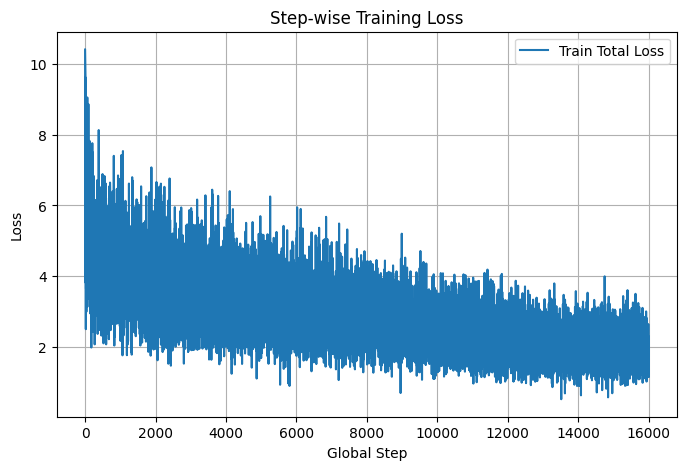

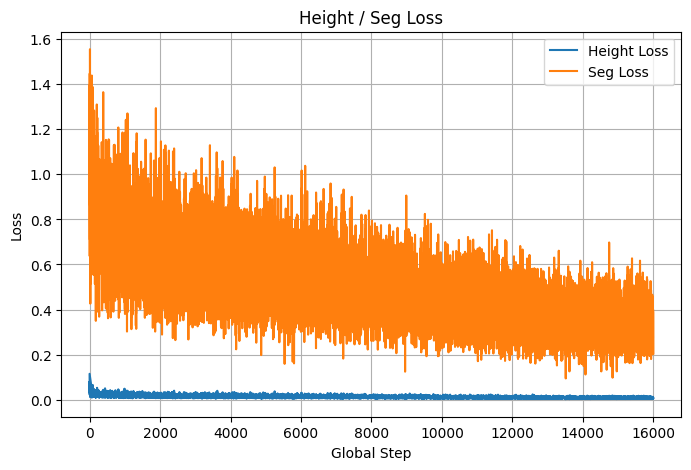

Validation loss (one-pass): 2.6875


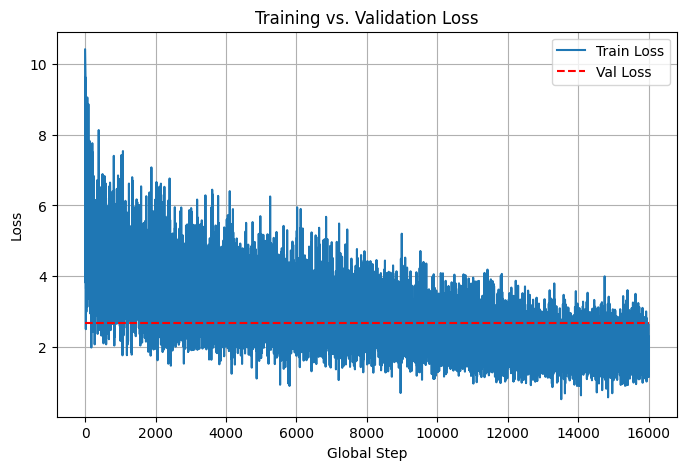

In [19]:
import matplotlib.pyplot as plt

steps = loss_history['step']
train_tot = loss_history['total_loss']

plt.figure(figsize=(8,5))
plt.plot(steps, train_tot, label='Train Total Loss')
plt.xlabel('Global Step')
plt.ylabel('Loss')
plt.title('Step-wise Training Loss')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(8,5))
plt.plot(steps, loss_history['height_loss'], label='Height Loss')
plt.plot(steps, loss_history['seg_loss'],    label='Seg Loss')
plt.xlabel('Global Step')
plt.ylabel('Loss')
plt.title('Height / Seg Loss')
plt.legend()
plt.grid(True)
plt.show()


import torch.nn.functional as F

model.eval()
total_val, n_batches = 0.0, 0

with torch.no_grad():
    for images, dsm_log, _, _ in val_loader:
        # ensure inputs are float32
        images  = images.float().to(device)
        dsm_log = dsm_log.float().to(device)
        
        # forward
        h_pred, s_pred = model(images)
        # upsample to match DSM
        h_pred = F.interpolate(h_pred, size=dsm_log.shape[-2:], 
                               mode='bilinear', align_corners=True)
        s_pred = F.interpolate(s_pred, size=dsm_log.shape[-2:], 
                               mode='bilinear', align_corners=True)
        
        # height loss
        h_loss = criterion(h_pred, dsm_log)
        
        # rebuild seg_labels exactly as in training
        dsm_gt     = torch.expm1(dsm_log * torch.log1p(torch.tensor(184., device=device)))
        seg_labels = torch.zeros_like(dsm_gt, dtype=torch.long, device=device)
        seg_labels[(dsm_gt >= 1e-6) & (dsm_gt < 10)] = 1
        seg_labels[(dsm_gt >= 10)  & (dsm_gt < 36)] = 2
        seg_labels[dsm_gt >= 36]              = 3
        seg_labels = seg_labels.squeeze(1)
        
        # segmentation loss
        s_loss = F.cross_entropy(s_pred, seg_labels)
        
        total_val += (height_loss_weight * h_loss + seg_loss_weight * s_loss).item()
        n_batches += 1

avg_val_loss = total_val / n_batches
print(f"Validation loss (one-pass): {avg_val_loss:.4f}")

# ————— Plotting —————
steps     = loss_history['step']
train_tot = loss_history['total_loss']

plt.figure(figsize=(8,5))
plt.plot(steps, train_tot, label='Train Loss')
plt.hlines(avg_val_loss, xmin=steps[0], xmax=steps[-1],
           colors='r', linestyles='--', label='Val Loss')
plt.xlabel('Global Step')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
model.eval()
test_rmse_total = 0
test_mae_total = 0
d1_total, d2_total, d3_total = 0, 0, 0
num_batches = 0

with torch.no_grad():
    for images, targets_log, _, _ in test_loader:
        images, targets_log = images.to(device).float(), targets_log.to(device).float()
        outputs_log = model(images)[0]
        
        outputs_log = F.interpolate(outputs_log, size=targets_log.shape[2:], mode='bilinear', align_corners=True)
        outputs_log = torch.clamp(outputs_log, min=0.0, max=5.3)
        
        targets = torch.expm1(targets_log * torch.log1p(torch.tensor(184.)))
        outputs = torch.expm1(outputs_log * torch.log1p(torch.tensor(184.)))
        
        # Accuracy Metrics
        rmse = torch.sqrt(F.mse_loss(outputs, targets)).item()
        mae = torch.mean(torch.abs(outputs - targets)).item()
        test_rmse_total += rmse
        test_mae_total += mae

        # Delta Metrics
        d1, d2, d3 = compute_delta_metrics(outputs, targets)
        d1_total += d1
        d2_total += d2
        d3_total += d3

        num_batches += 1

# Averages
avg_test_rmse = test_rmse_total / num_batches
avg_test_mae = test_mae_total / num_batches
avg_d1 = d1_total / num_batches
avg_d2 = d2_total / num_batches
avg_d3 = d3_total / num_batches

# Output
print(f"🧪 Final Test RMSE: {avg_test_rmse:.4f} | MAE: {avg_test_mae:.4f}")
print(f"📏 Final Test δ Metrics — δ₁: {avg_d1:.4f} | δ₂: {avg_d2:.4f} | δ₃: {avg_d3:.4f}")


🧪 Final Test RMSE: 7.9646 | MAE: 3.7871
📏 Final Test δ Metrics — δ₁: 0.0551 | δ₂: 0.1061 | δ₃: 0.1504



Sample 0:
  GT DSM Min: 0.0, Max: 34.61035919189453
  Pred DSM Min: 0.005872799549251795, Max: 82.803466796875

Sample 1:
  GT DSM Min: 0.0, Max: 64.86500549316406
  Pred DSM Min: 0.002370256930589676, Max: 62.131195068359375

Sample 2:
  GT DSM Min: 0.0, Max: 142.53404235839844
  Pred DSM Min: 0.042028915137052536, Max: 73.37739562988281

Sample 3:
  GT DSM Min: 0.0, Max: 20.9553165435791
  Pred DSM Min: 0.004717992153018713, Max: 52.83993911743164


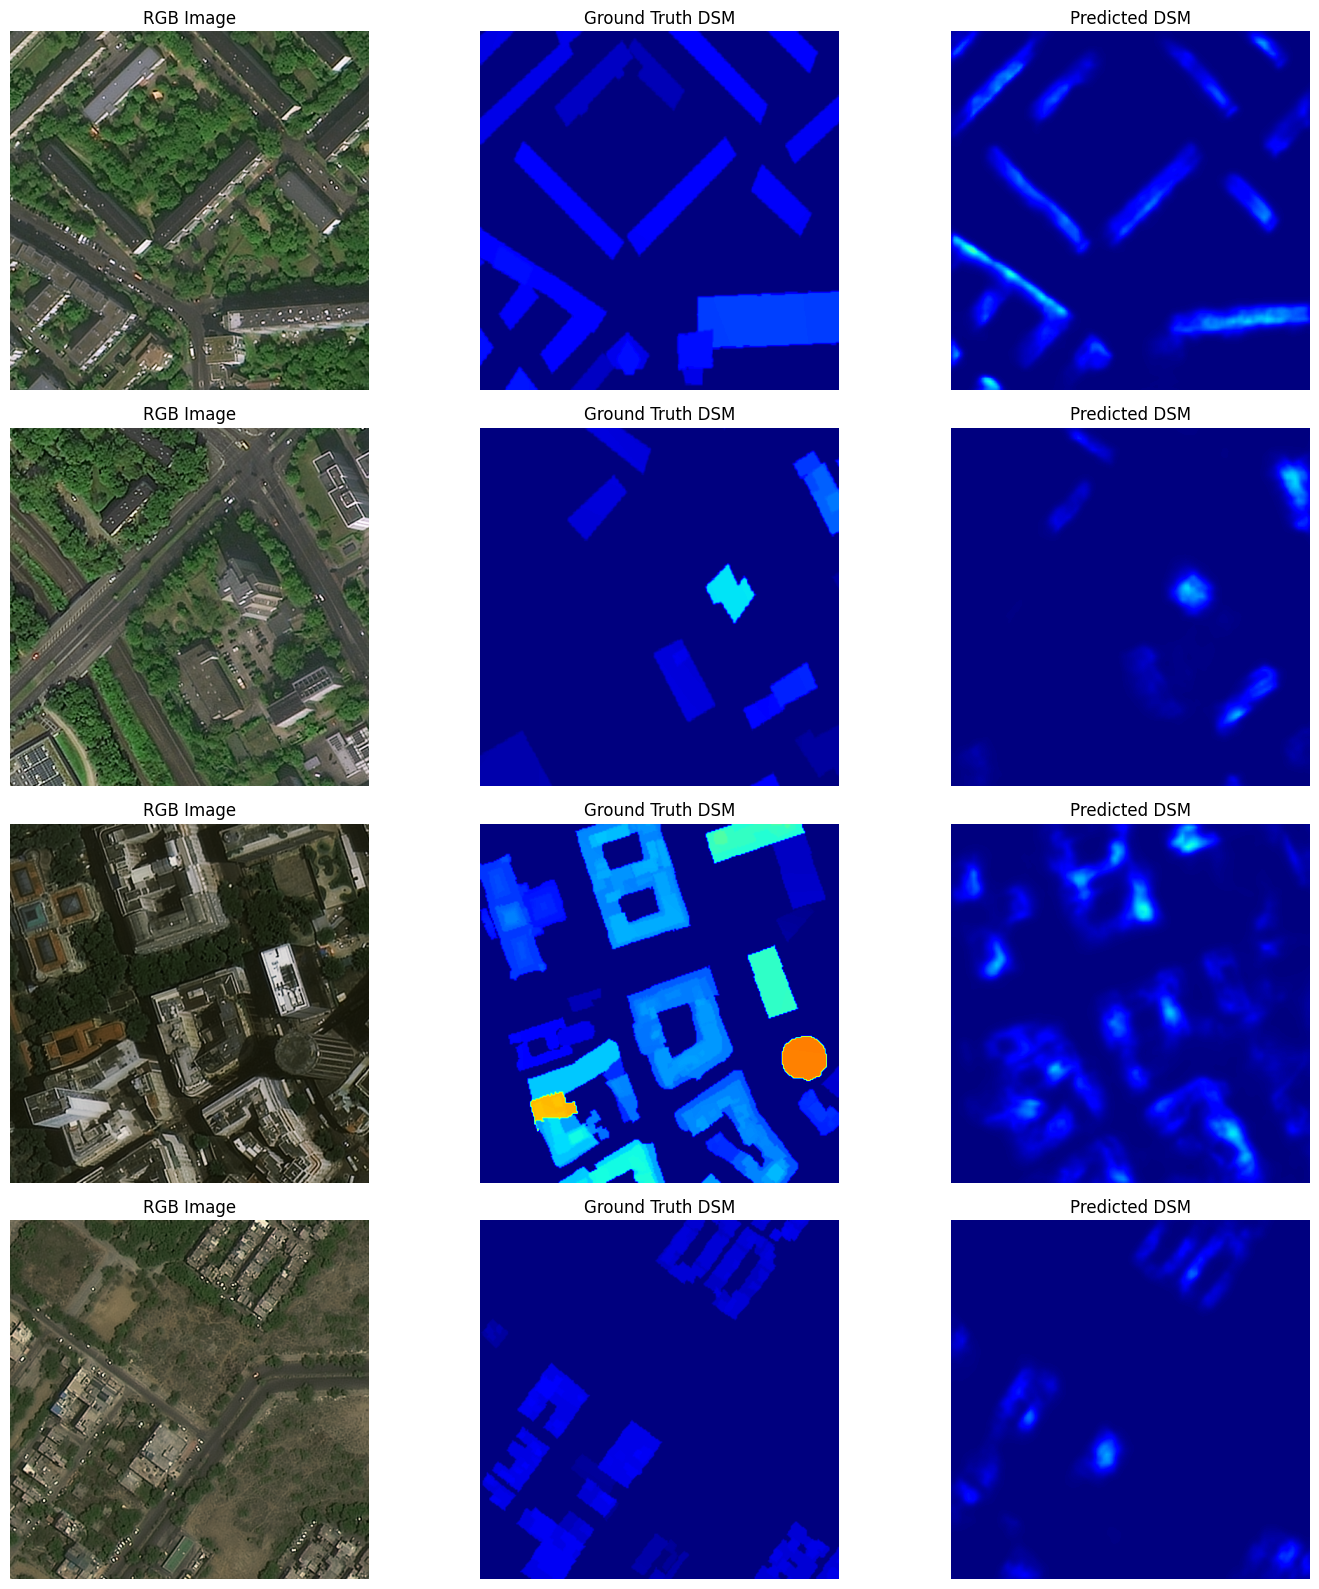

In [17]:
# Put model in evaluation mode
model.eval()

# Fetch one batch from test loader
images, targets_log, _, _ = next(iter(test_loader))
images = images.to(device).float()

targets = torch.expm1(targets_log * torch.log1p(torch.tensor(184.)))
# Get model prediction
with torch.no_grad():
    outputs_log = model(images)[0]
    outputs_log = F.interpolate(outputs_log,size=targets_log.shape[2:],mode='bilinear',align_corners=True)
    outputs_log = torch.clamp(outputs_log, min=0.0, max=5.3)
    
outputs = torch.expm1(outputs_log * torch.log1p(torch.tensor(184.)))

# Move everything to CPU for visualization
images = images.cpu().numpy()   # shape: (batch, 4, H, W)
targets = targets.cpu().numpy() # shape: (batch, 1, H, W)
outputs = outputs.cpu().numpy()

# Show results for a few samples
num_samples = min(4, images.shape[0])
plt.figure(figsize=(15, num_samples * 4))

for i in range(num_samples):
    print(f"\nSample {i}:")
    print(f"  GT DSM Min: {targets[i][0].min()}, Max: {targets[i][0].max()}")
    print(f"  Pred DSM Min: {outputs[i][0].min()}, Max: {outputs[i][0].max()}")

for i in range(num_samples):
    # ---- RGB Image ----
    plt.subplot(num_samples, 3, i * 3 + 1)
    # Extract only the first three channels (RGB)
    rgb = images[i][:3, :, :]            # (3, H, W)
    rgb = rgb.transpose(1, 2, 0)         # -> (H, W, 3)
    # Add mean back to each RGB channel
    rgb += np.array([128, 128, 128])     
    rgb = np.clip(rgb, 0, 255).astype(np.uint8)
    plt.imshow(rgb)
    plt.title("RGB Image")
    plt.axis('off')

    # ---- Ground Truth DSM ----
    plt.subplot(num_samples, 3, i * 3 + 2)
    gt_dsm = targets[i][0]
    plt.imshow(gt_dsm, cmap='jet', vmin=0, vmax=184)
    plt.title("Ground Truth DSM")
    plt.axis('off')
    
    # ---- Predicted DSM ----
    plt.subplot(num_samples, 3, i * 3 + 3)
    pred_dsm = outputs[i][0]
    plt.imshow(pred_dsm, cmap='jet', vmin=0, vmax=184)
    plt.title("Predicted DSM")
    plt.axis('off')

plt.tight_layout()
plt.show()


## Changes made

### Dataset:

Inclusion of SAR data - our original version did no such thing, I'm not quite sure how it still managed to perform, the given baseline did the same thing but it shouldn't have ever worked. Including SAR data was not trivial though sadly, requring quite a few changes to the get_item function of the dataset, along with some changes to the provided merge code (that one was provided in the baseline code)

No longer normalizing DSM values - to facilitate architectural change later on

### Architecture changes:

Switched to a DeepLab-style encoder-decoder semantic segmentation network, base model provided in the original DFC code. Made a couple of changes to include SAR data, as well as shifting from Sigmoid activation head to a ReLU one which via trial and error has proved to be better so far.

### Noticable issues:

Right now the model is acting more like a per pixel classifier, where the image segmentation part is coming along nicely but the height values - not so much. Need to identify how to fix it.

### Future plans:

Log-normalization of DSM values
Better handling of SAR data (right now its treated as just another channel)
More activation functions to explore besides ReLU, Sigmoid
Exploring different optimizers - for these sorta models apparently SGD outperforms Adam over more epochs.
